# Проект "Сервис для предсказания стоимости домов на основе истории предложений"

"Агентство недвижимости" 

К нам обратился представитель крупного агентства недвижимости со
следующей проблемой:
«Мои риелторы тратят катастрофически много времени на сортировку
объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
Это сказывается на наших финансовых показателях.

Наша задача — разработать модель, которая позволила бы обойти
конкурентов по скорости и качеству совершения сделок. Вот датасет для
работы».

Что необходимо сделать: разработать сервис для предсказания стоимости
домов на основе истории предложений.

In [1]:
# Импорт библиотек
import os
import sys
import warnings

# ==========================================
# 1. CPU ACCELERATION (Intel)
# ==========================================
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
    print('Intel Extension (CPU) активирован для sklearn')
except (ImportError, Exception):
    print('Intel Extension не найден, работаем на стандартном CPU')

# ==========================================
# 2. GPU ACCELERATION (NVIDIA RAPIDS)
# ==========================================
USE_GPU = False

# Попытка включить "Магический Pandas" (работает только в Jupyter)
# try:
#     from IPython.core.getipython import get_ipython
#     if get_ipython() is not None:
#         get_ipython().run_line_magic('load_ext', 'cudf.pandas')
#         print("Magic Mode: Pandas автоматически ускорен на GPU!")
#         USE_GPU = True
# except (ImportError, ModuleNotFoundError):
#     pass # Мы не в Jupyter или нет cudf.pandas

import pandas as pd
import numpy as np

# # Если магия не сработала (мы в скрипте .py), пробуем импортировать cudf явно
# if not USE_GPU:
#     try:
#         import cudf
#         print("Explicit Mode: Библиотека cuDF доступна (используйте cudf вместо pd)")
#         USE_GPU = True
#     except ImportError:
#         print("GPU не найден, работаем на чистом CPU")

# Импорт ML-библиотек (cuml)
# try:
#     import cuml
#     print("cuML (GPU Machine Learning) доступен")
# except ImportError:
#     pass

from IPython.display import display, Markdown
from matplotlib import pyplot as plt
from tqdm import tqdm

if USE_GPU:
    # Импортируем GPU-версии
    from cuml.ensemble import RandomForestClassifier
    from cuml.linear_model import LinearRegression, LogisticRegression
    from cuml.neighbors import KNeighborsClassifier
    from cuml.svm import SVC
    # Можно добавить любые другие модели, которые есть в cuML    
    print("Модели: загружены из cuML (GPU)")    
else:
    # Импортируем стандартные CPU-версии
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC    
    print("Модели: загружены из Scikit-learn (CPU)")


from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.optimize import minimize, least_squares

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'
from plotly.subplots import make_subplots


import ast
import datetime

from dmba import AIC_score, stepwise_selection
from catboost import CatBoostRegressor
import xgboost as xgb
import optuna
import pickle
import joblib

import scipy
import math

import time


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel Extension (CPU) активирован для sklearn
Модели: загружены из Scikit-learn (CPU)


In [2]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
sns.set_style("whitegrid")

SEED = 42

In [3]:
data = pd.read_csv(r'./data/data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


В датасете имеем 377185 разных объектов недвижимости описанных восемнадцатью признаками:

1. status - статус продажи
2. private pool - частный бассейн
3. propertyType - тип недвижимости
4. street - улица
5. baths - число ванных комнат 
6. homeFacts - сведения о доме 
7. fireplace - тип отопления
8. city - город
9. schools - школы
10. sqft - квадратный фут
11. zipcode - почтовый индекс
12. beds - число комнат
13. state - штат
14. stories - этажность
15. mls-id - это код в их централизованной системе учёта предложений объектов недвижимости
16. PrivatePool - частный бассейн
17. MlsId - это код в их централизованной системе учёта предложений объектов недвижимости
18. target - целевой признак, цена недвижимости


## 1. Первичный анализ и очистка данных

Проведем осмотр данных, проверим типы, наличие пропусков и дубликатов.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Все признаки имеют тип object, в том числе целевой.  Кроме того, имеются пропуски во всех признаках. 

Сформилируем дальнейшую схему работы/обработки данных на следующем этапе:

1. Привести целевой признак(target) к числовому типу
2. Обработать пропуски в целевом признаке(target)
3. Проанализировать и удалить неинформативные признаки
4. Отдельно обработать информацию в признаках homeFacts и school, содержащие пул данных
5. Обработать пропуски в остальных признаках
6. Спроектировать новые признаки
7. Визуализировать данные, найти зависимости, гипотезы

In [5]:
print(f"Размер датасета: {data.shape}")
duplicates = data.duplicated().sum()
print(f"Количество дубликатов: {duplicates} ({duplicates/len(data):.2%})")

Размер датасета: (377185, 18)
Количество дубликатов: 50 (0.01%)


### Удаление дубликатов
Дубликаты могут исказить результаты анализа и обучения модели. Удалим их.

In [6]:
data = data.drop_duplicates()
print(f"Размер после удаления дубликатов: {data.shape}")

Размер после удаления дубликатов: (377135, 18)


### Обработка целевой переменной (target)
Целевая переменная сейчас в строковом формате (содержит '$' и ','). Преобразуем ее в число.

In [7]:
def clean_currency(x):
    if isinstance(x, str):
        return x.replace('$', '').replace(',', '').replace('+', '')
    return x

data['target_clean'] = data['target'].apply(clean_currency)
data['target_clean'] = pd.to_numeric(data['target_clean'], errors='coerce')
# удаляем признак target
data = data.drop(['target'], axis=1)

print(f'Число пропусков в target_clean: {data["target_clean"].isnull().sum()}.')

Число пропусков в target_clean: 2878.


Имеем 2878 пропусков в целевой переменной, что составляет менее 1% от общего объёма датасета. 

На этом этапе можно было бы удалить строки с пропущенными значениями целевой переменной или заполнить пропуски медианными значениями целевой переменной, однако это не совсем корректно, так как мы не знаем, какие значения будут в этих строках и это может повлиять на качество модели.

Один из вариантов заполнения пропусков - заполнить медианными ценами на жильё в зависимости от штата(state) и типа недвижимости(propertyType), таким образом более гибко подойдём к заполнению пропусков

Данная функция может понадобиться в дальнейшем, например, если произойдут неравномерные изменения цен на недвижимость в разных штатах.

In [8]:
def pass_processing(df):
    """ Обрабатывает пропущенные значения в
    целевой переменной target_clean

       Args:
           df (DateFrame): датафрейм

       Returns:
           DataFrame: датафрейм с обработанным признаком
       """
   
    # датасет без пропущенных значений
    data_good = df[~df['target_clean'].isnull()]
    # лист с уникальными значениями штатов
    uni = list(data_good['state'].unique())
    # датасет-справочник с медианными ценами в разрезе штатов и типов недвижимости
    df_values = pd.DataFrame(data_good[data_good.state.isin(uni)].groupby(['state', 'propertyType'])['target_clean'].median().reset_index())
    # для удобства объединим столбцы state и propertyType в state_type_values
    df_values['state_type_values'] = df_values['state'] + '_' + df_values['propertyType']
    df['state_type_values'] = df['state'] + '_' + df['propertyType']
    # удалим лишние столбцы
    df_values = df_values.drop(['state', 'propertyType'], axis=1)
    
    # объединяем исходный датафрейм с данными из справочника 
    df_merge = df.merge(
    df_values,
    on='state_type_values',
    how='left'
           )
    # заполним пропущенные значения на No для удобства
    df_merge['target_clean_x'] = df_merge['target_clean_x'].fillna('No')
    # обрабатываем пропуски в целевом столбце
    df_merge['target_clean_x'] = df_merge.apply(lambda x: x.target_clean_y if x.target_clean_x=='No' else x.target_clean_x, axis=1)
    # удаляем лишние столбцы 
    df_merge = df_merge.drop(['state_type_values', 'target_clean_y'], axis=1).rename(columns={'target_clean_x':'target_clean'})
    # заполняем недостающие пропуски, которых не было в справочнике на медиану
    df_merge['target_clean'] = df_merge['target_clean'].fillna(df['target_clean'].median())
    
    return df_merge

data = pass_processing(data)
print(f'Количество пропусков целевой переменной = {data["target_clean"].isnull().sum()}.')   

Количество пропусков целевой переменной = 0.


Описательные статистики по целевой переменной(target_clear):

In [9]:
print("Основные статистики Price:")
print(data['target_clean'].describe())

Основные статистики Price:
count    3.771350e+05
mean     6.432407e+05
std      1.835440e+06
min      1.000000e+00
25%      1.890000e+05
50%      3.200000e+05
75%      5.800000e+05
max      1.950000e+08
Name: target_clean, dtype: float64


Медианная стоимость недвижимости $320 000 
Средняя стоимость недвижимости $643 240,7 , что превышаем медианную стоимость в 2 раза.
Кроме того, предположительно имеют место выбросы (минимальная стоимость $1, максимальная стоимость $195 000 000).
В таком случае именно медианное значение цены будет лучше отражать меру центральной тенденции так как оно устойчиво к выбросам. 

Изучим распределение целевой переменной:

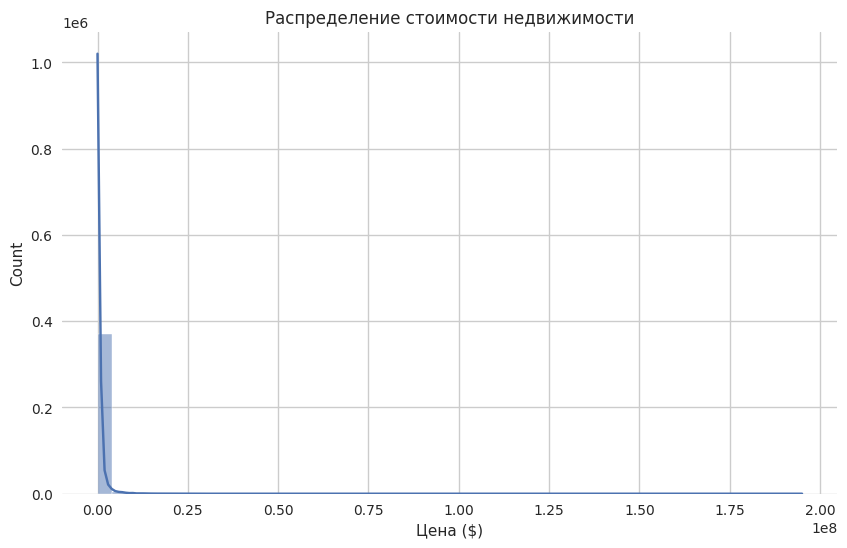

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data['target_clean'], bins=50, kde=True)
plt.title('Распределение стоимости недвижимости')
plt.xlabel('Цена ($)')
plt.show()

Исходная гистограмма цен крайне неинформативна: из-за экстремальных выбросов (до $2 \times 10^8$) основное распределение "схлопнулось" в узкий пик около нуля. Чтобы избавиться от влияния этого длинного хвоста и сделать структуру данных видимой, мы применили логарифмическую трансформацию к целевой переменной



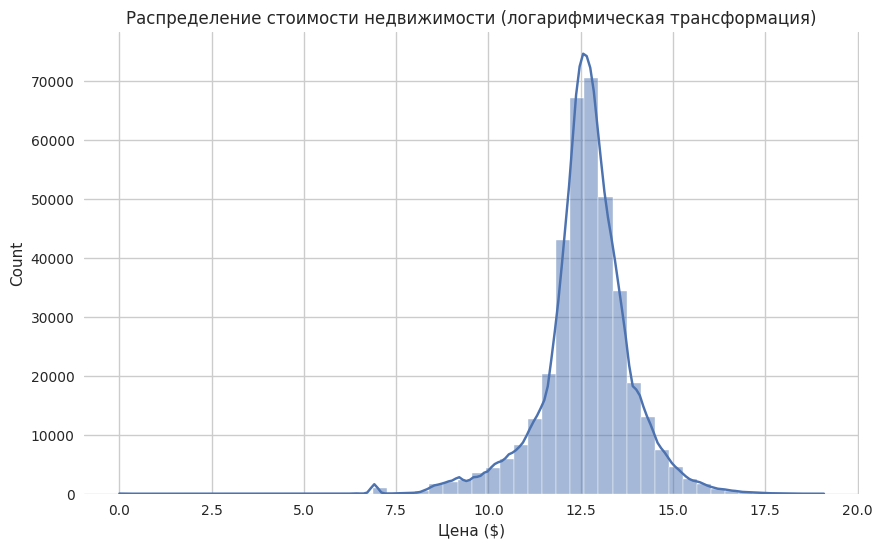

In [11]:
data['target_clean_log'] = np.log(data['target_clean'])

plt.figure(figsize=(10, 6))
sns.histplot(data['target_clean_log'], bins=50, kde=True)
plt.title('Распределение стоимости недвижимости (логарифмическая трансформация)')
plt.xlabel('Цена ($)')
plt.show()


Избавимся от выбросов по целевому признаку, для этого воспользуемся методом Тьюки, применив его к логарифмированному признаку:

In [12]:
def find_outliers_iqr(df, feature, left=1.5, right=1.5, log_scale=False):
    """
    Находит выбросы в данных, используя метод межквартильного размаха. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        df (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """
    if log_scale:
        x = np.log(df[feature]+1)
    else:
        x= df[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = df[(x<lower_bound) | (x > upper_bound)]
    cleaned = df[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

print(f'Тип ассиметрии до очистки: {data["target_clean_log"].skew()}')
outliers, data = find_outliers_iqr(data, 'target_clean_log')
print(f'Тип ассиметрии после очистки: {data["target_clean_log"].skew()}')

Тип ассиметрии до очистки: -0.6483176311562571
Тип ассиметрии после очистки: 0.03135297777271554


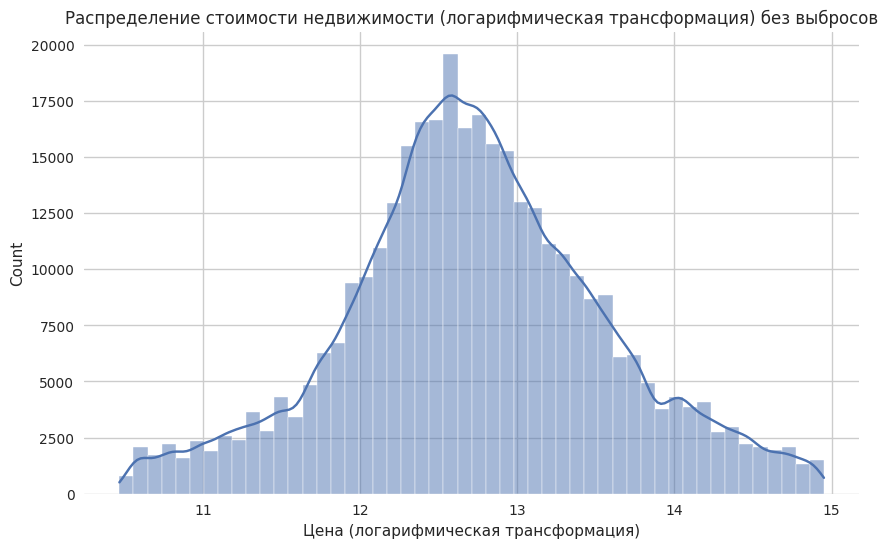

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data['target_clean_log'], bins=50, kde=True)
plt.title('Распределение стоимости недвижимости (логарифмическая трансформация) без выбросов')
plt.xlabel('Цена (логарифмическая трансформация)')
plt.show()


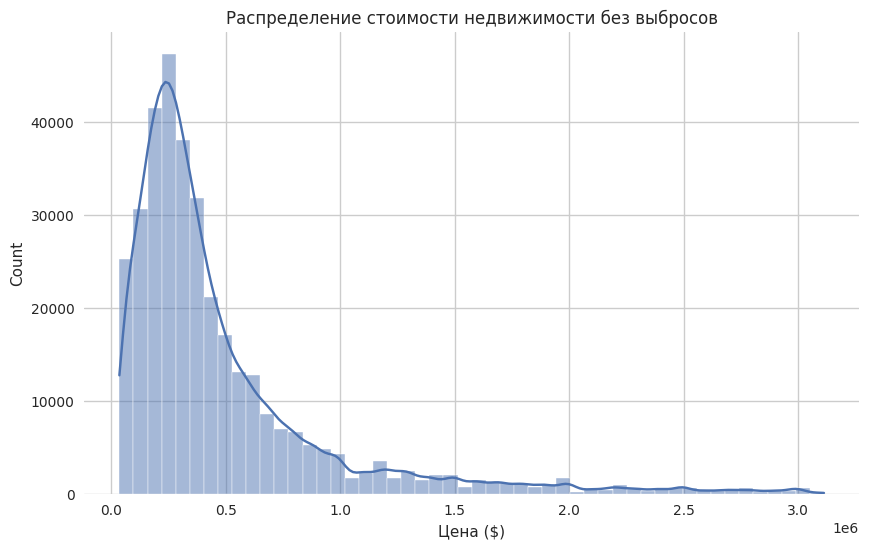

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data['target_clean'], bins=50, kde=True)
plt.title('Распределение стоимости недвижимости без выбросов')
plt.xlabel('Цена ($)')
plt.show()

In [14]:
print(f'Число наблюдений {data.shape[0]}.')
data['target_clean'].describe()

Число наблюдений 349346.


count    3.493460e+05
mean     4.825439e+05
std      4.757327e+05
min      3.517800e+04
25%      2.029000e+05
50%      3.290000e+05
75%      5.699000e+05
max      3.112678e+06
Name: target_clean, dtype: float64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349346 entries, 0 to 377134
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            310943 non-null  object 
 1   private pool      4009 non-null    object 
 2   propertyType      319588 non-null  object 
 3   street            349344 non-null  object 
 4   baths             259340 non-null  object 
 5   homeFacts         349346 non-null  object 
 6   fireplace         98728 non-null   object 
 7   city              349326 non-null  object 
 8   schools           349346 non-null  object 
 9   sqft              319214 non-null  object 
 10  zipcode           349346 non-null  object 
 11  beds              274315 non-null  object 
 12  state             349346 non-null  object 
 13  stories           218530 non-null  object 
 14  mls-id            24175 non-null   object 
 15  PrivatePool       37218 non-null   object 
 16  MlsId             285118 

После очистки датасета количество наблюдений уменьшилось до 341690, аномальные значения в виде $1 или $195 млн. были удалены. 

## Анализ неинформативных признаков

Изучим потенциальные неинформативные признаки 
- наличие частного бассейна - private pool 
- наличие частного бассейна - PrivatePool, 
- наличие каминов - fireplace 

- в них порядка 65-85% пропусков и они кандидаты на удаление, 

признаки MlsId и mls-id, которые являются уникальными номерами в базе данных в системе множественного листинга и никакой информативности не несут.


In [20]:
display(data['private pool'].describe())
display(data['private pool'].value_counts())

count     4009
unique       1
top        Yes
freq      4009
Name: private pool, dtype: object

private pool
Yes    4009
Name: count, dtype: int64

In [21]:
display(data['PrivatePool'].describe())
display(data['PrivatePool'].value_counts())

count     37218
unique        2
top         yes
freq      26791
Name: PrivatePool, dtype: object

PrivatePool
yes    26791
Yes    10427
Name: count, dtype: int64

In [22]:
display(data['fireplace'].describe())
display(data['fireplace'].value_counts())

count     98728
unique     1608
top         yes
freq      47813
Name: fireplace, dtype: object

fireplace
yes                                                                47813
Yes                                                                19856
1                                                                  14415
2                                                                   2313
Not Applicable                                                      1992
                                                                   ...  
Built-Ins, Fireplace - Electric, Flooring - HardWood                   1
Other - See Remarks                                                    1
Living Room, See Thru                                                  1
Family Room Fireplace, Gas Log Fireplace, Gas Starter Fireplace        1
Masonry, Living Room, Family Room, Master Bedroom                      1
Name: count, Length: 1608, dtype: int64

In [24]:
def date_clear(df, no_inf_1, no_inf_2):
    """ Удаляет столбцы, в которых доля пропущенных значений > 60%,
    а также неинформативные признаки

    Args:
        df (DateFrame): исходный датафрейм
        no_inf_1 (Series): первый неинформативный признак
        no_inf_2 (Series): второй неинформативный признак

    Returns:
        DateFrame: очищенный датафрейм
    """
    df = df.drop([no_inf_1, no_inf_2], axis=1)
    #задаем минимальный порог: вычисляем 60% от числа строк
    thresh = df.shape[0]*0.6
    #удаляем столбцы, в которых более 30% (100-70) пропусков
    df = df.dropna(thresh=thresh, axis=1)
    return df

data = date_clear(data, 'mls-id', 'MlsId')



In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349346 entries, 0 to 377134
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            310943 non-null  object 
 1   propertyType      319588 non-null  object 
 2   street            349344 non-null  object 
 3   baths             259340 non-null  object 
 4   homeFacts         349346 non-null  object 
 5   city              349326 non-null  object 
 6   schools           349346 non-null  object 
 7   sqft              319214 non-null  object 
 8   zipcode           349346 non-null  object 
 9   beds              274315 non-null  object 
 10  state             349346 non-null  object 
 11  stories           218530 non-null  object 
 12  target_clean      349346 non-null  float64
 13  target_clean_log  349346 non-null  float64
dtypes: float64(2), object(12)
memory usage: 40.0+ MB
